In [1]:
from bokeh.io import output_notebook
from bokeh.models import Label
from bokeh.plotting import figure, output_file, show
from collections import Counter
from functools import reduce
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from IPython.core.interactiveshell import InteractiveShell
from nltk.corpus import stopwords
from plotly.offline import iplot
from pprint import pprint
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from textblob import TextBlob
import collections
import csv
import cufflinks
import emoji
import en_core_web_sm
import gensim
import gensim.corpora as corpora
import itertools
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import pyLDAvis
import re
import scattertext as st
import seaborn as sns
import spacy
import spacy
import warnings 

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


from scipy import stats ## Needed for stats test
import statsmodels.api as sm
from wordcloud import WordCloud, STOPWORDS

from matplotlib import pyplot as plt


In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')
InteractiveShell.ast_node_interactivity = 'all'
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

output_notebook()
pd.options.display.max_columns = 30
warnings.filterwarnings('ignore')

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

nlp = spacy.load('en_core_web_sm')

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



Loading BokehJS ...

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



In [3]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
words = set(nltk.corpus.words.words())

In [5]:
filename: str = "./../assets/ifa-ie-articles.csv"
df = pd.read_csv(filename)

df.columns 

Index(['URL', 'Heading', 'Date', 'Trend', 'Text', 'HTML Content'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   URL           872 non-null    object
 1   Heading       872 non-null    object
 2   Date          872 non-null    object
 3   Trend         872 non-null    object
 4   Text          872 non-null    object
 5   HTML Content  872 non-null    object
dtypes: object(6)
memory usage: 41.0+ KB


In [7]:
def vader_scorer(df):
    '''Compute vaderSentiment scores for each tweet
    Args: Dataframe containing a 'text' column
    Returns: Dataframe of vader scores
    '''
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = df.loc[:,'Text'].map(analyzer.polarity_scores)

    dvec = DictVectorizer()
    vader_scores = dvec.fit_transform(vader_scores)
    
    vader_scores = pd.DataFrame(vader_scores.toarray(),columns=dvec.feature_names_)
    return vader_scores

In [8]:
vader_scores = vader_scorer(df)
df = pd.concat([df,vader_scores], axis=1)

In [9]:
# make trend lower case - mm
df.columns = ['URL', 'Heading', 'Date', 'trend', 'Text', 'HTML Content', 'compound',
       'neg', 'neu', 'pos']

In [10]:
beef_dataframe = df[df['trend'] == 'cattle'] # was 'beef'
dairy_dataframe = df[df['trend'] == 'dairy']
#TODO: Michael
beef_dataframe.head()
dairy_dataframe.head()

,URL,Heading,Date,trend,Text,HTML Content,compound,neg,neu,pos
0,https://www.ifa.ie/markets-and-prices/weekly-c...,Weekly Cattle Prices 26th January,26 January 2022,cattle,\r\nPrices reported as quoted or paid to IFA M...,"<div class=""single-content"">\r\n<p>Prices repo...",0.8689,0.012,0.908,0.080
1,https://www.ifa.ie/regional/wexford-ifa-fertil...,Wexford IFA Fertiliser Seminar 24th January,25 January 2022,cattle,\r\nWexford IFA held an online public open mee...,"<div class=""single-content"">\r\n<p>Wexford IFA...",-0.6249,0.046,0.954,0.000
2,https://www.ifa.ie/markets-and-prices/beef-she...,Beef & Sheep Update 21st January,22 January 2022,cattle,\r\nBeef Update\r\nIFA Livestock chairman Bren...,"<div class=""single-content"">\r\n<h2>Beef Updat...",0.9501,0.037,0.897,0.065
3,https://www.ifa.ie/campaigns/key-amendments-on...,"Key Amendments on Animal Transport Carried, Bu...",20 January 2022,cattle,\r\nIFA President Tim Cullinan said the voting...,"<div class=""single-content"">\r\n<p>IFA Preside...",0.8193,0.048,0.862,0.090
4,https://www.ifa.ie/markets-and-prices/weekly-c...,Weekly Cattle Prices 19th January,19 January 2022,cattle,\r\nPrices reported as quoted or paid to IFA M...,"<div class=""single-content"">\r\n<p>Prices repo...",0.8689,0.012,0.907,0.081


,URL,Heading,Date,trend,Text,HTML Content,compound,neg,neu,pos
630,https://www.ifa.ie/farm-sectors/ifa-to-hold-da...,IFA to Hold Dairy Calf Webinar as Calving Seas...,26 January 2022,dairy,\r\n\r\n\r\nClick on the link below to join th...,"<div class=""single-content"">\r\n<div class=""wp...",0.7717,0.036,0.880,0.084
631,https://www.ifa.ie/regional/wexford-ifa-fertil...,Wexford IFA Fertiliser Seminar 24th January,25 January 2022,dairy,\r\nWexford IFA held an online public open mee...,"<div class=""single-content"">\r\n<p>Wexford IFA...",-0.6249,0.046,0.954,0.000
632,https://www.ifa.ie/farm-sectors/ifa-calf-webin...,"IFA Calf Webinar Moved to Wed, Jan 26th",24 January 2022,dairy,\r\nIFA’s Dairy Calf webinar is taking place o...,"<div class=""single-content"">\r\n<p>IFA’s Dairy...",0.9201,0.018,0.885,0.097
633,https://www.ifa.ie/campaigns/key-amendments-on...,"Key Amendments on Animal Transport Carried, Bu...",20 January 2022,dairy,\r\nIFA President Tim Cullinan said the voting...,"<div class=""single-content"">\r\n<p>IFA Preside...",0.8193,0.048,0.862,0.090
634,https://www.ifa.ie/policy-areas/food-exports-s...,Food Exports Show the Importance of the Sector...,12 January 2022,dairy,\r\nIFA President Tim Cullinan said the figure...,"<div class=""single-content"">\r\n<p>IFA Preside...",0.9799,0.006,0.869,0.125


Hypothesis 1:
Null Hypothesis is that sentiment for the beef and the dairy was the same

<AxesSubplot:xlabel='trend', ylabel='compound'>

<AxesSubplot:xlabel='trend', ylabel='compound'>

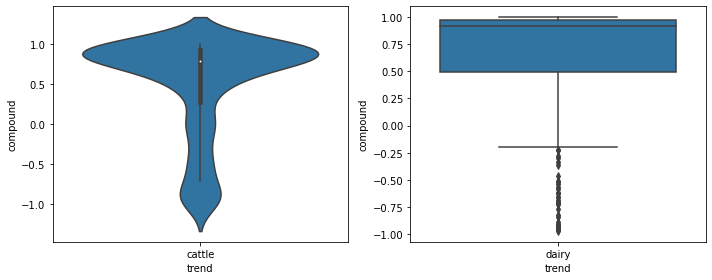

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
sns.violinplot(y='compound', x='trend', data=beef_dataframe, ax=ax[0]) 
sns.boxplot(y='compound', x='trend', data=dairy_dataframe, ax=ax[1])
plt.tight_layout()
#show.plt  # Was producing error - don't know what it is meant to do.

#plt.show()

In [13]:
print('StDev of beef sentiment',np.std(df[df.trend == 'cattle']['compound']))
print('StDev of NHS sentiment',np.std(df[df.trend == 'dairy']['compound']))

StDev of beef sentiment 0.6208893387928167
StDev of NHS sentiment 0.5937943328827562


Running SciPy's t-test:

Note: had sample standard deviations not been equal, then set equal_var = False to use Welch's t-statistic (ie. out standard error is calculated differently because we can't pool our two distributions together)

In [14]:
stats.ttest_ind(df[df.trend == 'cattle']['compound'],
                df[df.trend == 'dairy']['compound'], equal_var=True)

Ttest_indResult(statistic=-2.094357544561826, pvalue=0.03651693332379792)

Alternatively could have run Statsmodel API's ztest:

In [15]:
sm.stats.ztest(df[df.trend == 'cattle']['compound'],
               df[df.trend == 'dairy']['compound'])

(-2.0943575445618254, 0.03622814174843738)

So p-value is essentially 0, which says that if null hypothesis is assumed to be true, then there is 0 (or very small) chance of observing what we've just observed as the alternate hypothesis.
How small the p-value is, assuming proper statistical process, is how much confidence we have in rejecting the null hypothesis. Because we're saying there's no chance we'd have seen this alternate hypothesis (so far into the tail as it was) if the null was true.
We can construct a 95% confidence interval for our difference in sample means to further confirm this:

In [16]:
p_bf = np.mean(df[df.trend == 'cattle']['compound'])
p_dr = np.mean(df[df.trend == 'dairy']['compound'])

num_bf = len(df[df.trend == 'cattle'])
num_dr = len(df[df.trend == 'dairy'])

The s.e. for each population (as we're comparing MEANS here) is simply: sigma / sqrt(n)

In [17]:
se_bf = np.std(df[df.trend == 'cattle']['compound']) / np.sqrt(num_bf)
se_dr = np.std(df[df.trend == 'dairy']['compound']) / np.sqrt(num_dr)

Alternatively, statsmodels has a function s.e. of the mean of a distribution:

In [18]:
print('beef sentiment s.e.', stats.sem(df[df.trend == 'cattle']['compound'], axis=None))
print('dairy sentiment s.e.', stats.sem(df[df.trend == 'dairy']['compound'], axis=None))

beef sentiment s.e. 0.02475647916755488
dairy sentiment s.e. 0.03824965542456881


With the standard error for both populations to be used in CI formula below: SE(1,2) = SQR(SE1^2 + SE2^2)

In [19]:
se_diff = np.sqrt(se_bf**2 + se_dr**2) # Was se_br**2 + se_dr**2

In [20]:
diff = p_bf - p_dr
lcb = diff - (1.96 * se_diff)
ucb = diff + (1.96 * se_diff)
(lcb, ucb)

(-0.18643397077186546, -0.008132092457835235)

Visualise sentiment
Can we visualise what type of sentiment ifi had for the beef vs the dairy? Let's look at the words that were being used to better understand how the ifi described each entity:

Text(0.5, 1.0, 'beef')

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'dairy')

(-0.5, 399.5, 199.5, -0.5)

<function matplotlib.pyplot.show(close=None, block=None)>

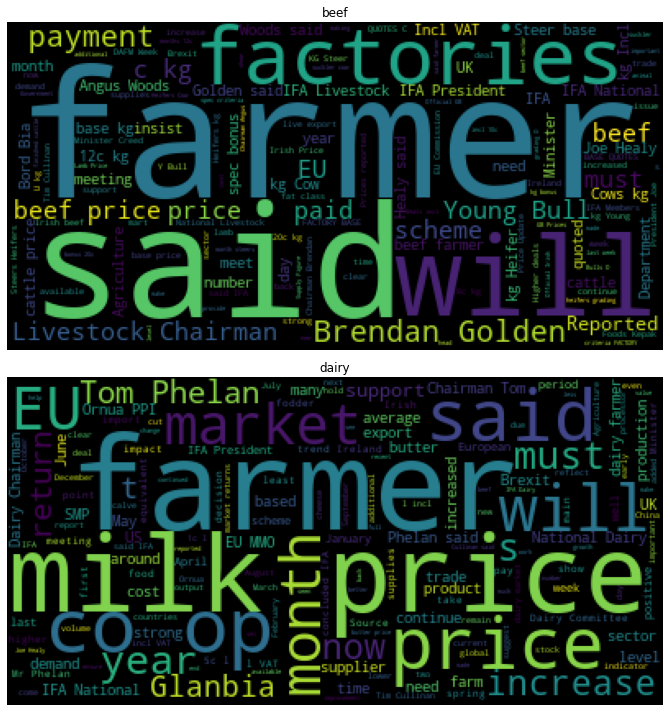

In [21]:



beef_text = " ".join(art for art in df.Text[df.trend=='cattle']) # Changed to cattle
dairy_text = " ".join(art for art in df.Text[df.trend=='dairy'])

stopwords = set(STOPWORDS)
stopwords.update(['http', 'https', 'www', 'amp', 'ly', 'bit'])

beef_wordcloud = WordCloud(stopwords=stopwords).generate(beef_text)
dairy_wordcloud = WordCloud(stopwords=stopwords).generate(dairy_text)

fig, ax = plt.subplots(nrows=2, figsize=(10,10))
ax[0].imshow(beef_wordcloud)
ax[0].set_title('beef')
ax[0].axis('off')
ax[1].imshow(dairy_wordcloud)
ax[1].set_title('dairy')
ax[1].axis('off')
plt.tight_layout()
plt.show